# NW-UCLA Dataset Exploratory Data Analysis

This notebook performs comprehensive EDA on the NW-UCLA skeleton action recognition dataset.

## Dataset Information
- **Actions**: 10 action classes
- **Joints**: 20 joints per skeleton
- **Persons**: 1 person per sample
- **Format**: JSON files
- **Location**: `data/NW-UCLA/all_sqe/`

In [1]:
# Import required libraries
import numpy as np
import pandas as pd
import json
import pickle
import os
import glob
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

print("Libraries imported successfully!")

Libraries imported successfully!


## 1. Dataset Overview

### 1.1 Basic Statistics

In [2]:
# Define paths
DATA_ROOT = Path('../data/NW-UCLA/all_sqe')


# Get all JSON files
all_json_files = sorted(glob.glob(str(DATA_ROOT / '*.json')))
print(f"Total JSON files: {len(all_json_files)}")


Total JSON files: 1484


In [3]:
# Parse file names to extract metadata
def parse_filename(filename):
    """Parse NW-UCLA filename and load label from JSON"""
    basename = Path(filename).stem
    parts = basename.split("_")
    
    # Load label from JSON file
    with open(filename, "r") as f:
        data = json.load(f)
    label = data.get("label", None)
    
    return {
        "action": label,
        "subject": int(parts[1][1:]),
        "environment": int(parts[2][1:]),
        "view": int(parts[3][1:]),
        "file_name": basename
    }

# Parse all files
file_info = [parse_filename(f) for f in all_json_files]
df_files = pd.DataFrame(file_info)


print("File information parsed!")
print(f"\nDataset Statistics:")
print(f"  Total samples: {len(df_files)}")
print(f"  Action classes: {df_files['action'].nunique()} (range: {df_files['action'].min()}-{df_files['action'].max()})")
print(f"  All action classes: {df_files['action'].unique()}")
print(f"  Subjects: {df_files['subject'].nunique()} (range: {df_files['subject'].min()}-{df_files['subject'].max()})")
print(f"  Views: {df_files['view'].nunique()} (values: {sorted(df_files['view'].unique())})")
print(f"  Environments: {df_files['environment'].nunique()} (range: {df_files['environment'].min()}-{df_files['environment'].max()})")


File information parsed!

Dataset Statistics:
  Total samples: 1484
  Action classes: 10 (range: 1-10)
  All action classes: [ 1  2  3  4  5  6  7  8  9 10]
  Subjects: 10 (range: 1-10)
  Views: 3 (values: [np.int64(1), np.int64(2), np.int64(3)])
  Environments: 11 (range: 0-10)


### 1.3 Action Class Distribution

Action Class Distribution:
action
1     150
2     152
3     141
4     173
5     148
6     149
7     142
8     142
9     145
10    142
Name: count, dtype: int64


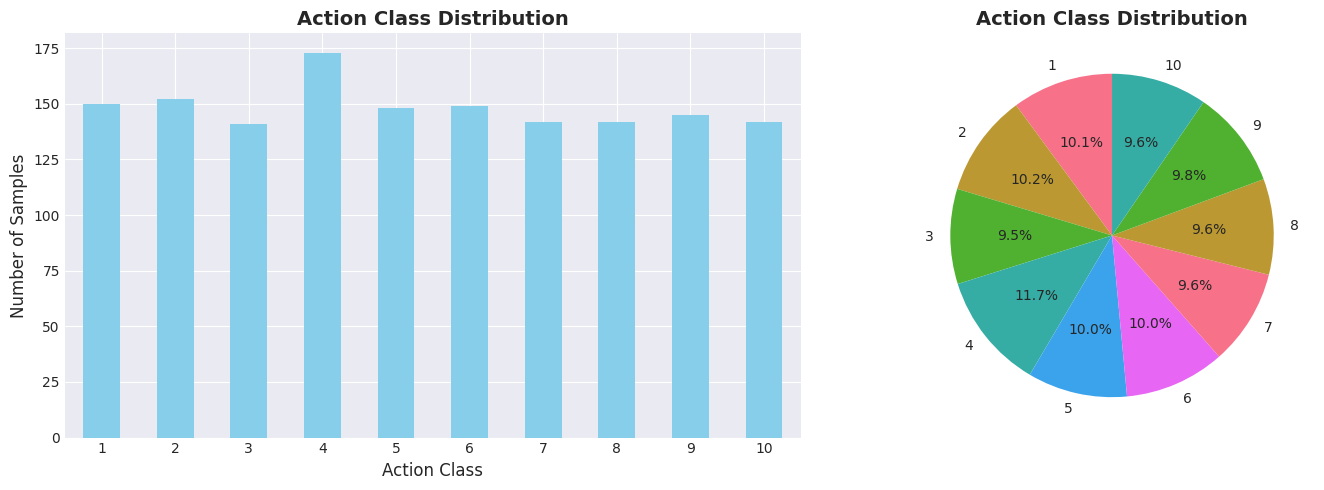

Class Imbalance Analysis:
  Min samples per class: 141
  Max samples per class: 173
  Mean samples per class: 148.4
  Std samples per class: 9.5
  Imbalance ratio (max/min): 1.23


In [4]:
# Action class distribution
action_counts = df_files["action"].value_counts().sort_index()

print("Action Class Distribution:")
print(action_counts)

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Bar plot
action_counts.plot(kind="bar", ax=axes[0], color="skyblue")
axes[0].set_title("Action Class Distribution", fontsize=14, fontweight="bold")
axes[0].set_xlabel("Action Class", fontsize=12)
axes[0].set_ylabel("Number of Samples", fontsize=12)
axes[0].set_xticklabels(action_counts.index, rotation=0)

# Pie chart for overall distribution
action_counts.plot(kind="pie", ax=axes[1], autopct="%1.1f%%", startangle=90)
axes[1].set_title("Action Class Distribution", fontsize=14, fontweight="bold")
axes[1].set_ylabel("")

plt.tight_layout()
plt.show()

# Check for class imbalance
print(f"Class Imbalance Analysis:")
print(f"  Min samples per class: {action_counts.min()}")
print(f"  Max samples per class: {action_counts.max()}")
print(f"  Mean samples per class: {action_counts.mean():.1f}")
print(f"  Std samples per class: {action_counts.std():.1f}")
print(f"  Imbalance ratio (max/min): {action_counts.max() / action_counts.min():.2f}")


## 2. File Format & Data Schema

### 2.1 NW-UCLA JSON Structure

In [5]:
# Load and inspect a sample JSON file
sample_file = all_json_files[0]
print(f"Sample file: {Path(sample_file).name}")

with open(sample_file, 'r') as f:
    sample_data = json.load(f)

print(f"\nJSON Structure:")
print(f"  Keys: {list(sample_data.keys())}")
print(f"  File name: {sample_data.get('file_name', 'N/A')}")
print(f"  Label: {sample_data.get('label', 'N/A')}")
print(f"  Number of frames: {len(sample_data.get('skeletons', []))}")

# Inspect skeleton structure
if sample_data.get('skeletons'):
    first_frame = sample_data['skeletons'][0]
    print(f"\nFirst Frame Structure:")
    print(f"  Type: {type(first_frame)}")
    print(f"  Length: {len(first_frame)}")
    print(f"  First joint (sample): {first_frame[0] if len(first_frame) > 0 else 'N/A'}")
    
    # Check if it's a list of lists or numpy array
    if isinstance(first_frame[0], (list, tuple)):
        print(f"  Joint coordinates shape: {len(first_frame[0])}D")
        print(f"  Sample joint coordinates: {first_frame[0]}")
    else:
        print(f"  Joint format: {type(first_frame[0])}")

# Load as numpy array to check shape
sample_skeletons = np.array(sample_data['skeletons'])
print(f"\nNumpy Array Shape:")
print(f"  Shape: {sample_skeletons.shape}")
print(f"  Data type: {sample_skeletons.dtype}")
print(f"  Min value: {sample_skeletons.min():.2f}")
print(f"  Max value: {sample_skeletons.max():.2f}")
print(f"  Mean value: {sample_skeletons.mean():.2f}")
print(f"  Std value: {sample_skeletons.std():.2f}")

Sample file: a01_s01_e00_v01.json

JSON Structure:
  Keys: ['file_name', 'skeletons', 'label']
  File name: a01_s01_e00_v01
  Label: 1
  Number of frames: 44

First Frame Structure:
  Type: <class 'list'>
  Length: 20
  First joint (sample): [-0.619699, 0.328046, 3.18186]
  Joint coordinates shape: 3D
  Sample joint coordinates: [-0.619699, 0.328046, 3.18186]

Numpy Array Shape:
  Shape: (44, 20, 3)
  Data type: float64
  Min value: -0.91
  Max value: 3.53
  Mean value: 0.83
  Std value: 1.54


### 2.3 Data Shape Analysis

In [6]:
# Analyze data shapes across all files
def get_file_stats(filepath):
    """Get statistics for a single JSON file"""
    with open(filepath, 'r') as f:
        data = json.load(f)
    skeletons = np.array(data['skeletons'])
    return {
        'file_name': Path(filepath).stem,
        'num_frames': skeletons.shape[0],
        'num_joints': skeletons.shape[1] if len(skeletons.shape) > 1 else 0,
        'coords_per_joint': skeletons.shape[2] if len(skeletons.shape) > 2 else 0,
        'min_coord': skeletons.min(),
        'max_coord': skeletons.max(),
        'mean_coord': skeletons.mean(),
        'std_coord': skeletons.std()
    }

# Process a sample of files (to avoid long processing time)
sample_size = min(100, len(all_json_files))
sample_files = np.random.choice(all_json_files, sample_size, replace=False)

print(f"Analyzing {sample_size} sample files...")
file_stats = []
for f in sample_files:
    try:
        stats = get_file_stats(f)
        file_stats.append(stats)
    except Exception as e:
        print(f"Error processing {f}: {e}")

df_stats = pd.DataFrame(file_stats)
print("\nData Shape Statistics:")
print(df_stats.describe())

Analyzing 100 sample files...

Data Shape Statistics:
       num_frames  num_joints  coords_per_joint   min_coord   max_coord  \
count  100.000000       100.0             100.0  100.000000  100.000000   
mean    39.300000        20.0               3.0   -0.890734    3.272261   
std     29.129977         0.0               0.0    0.239132    0.365658   
min      6.000000        20.0               3.0   -1.712870    2.134730   
25%     21.750000        20.0               3.0   -0.943939    3.074660   
50%     29.000000        20.0               3.0   -0.869945    3.236310   
75%     49.250000        20.0               3.0   -0.736421    3.453470   
max    146.000000        20.0               3.0   -0.260485    4.179230   

       mean_coord   std_coord  
count  100.000000  100.000000  
mean     0.939079    1.325924  
std      0.189817    0.155896  
min      0.562989    0.870920  
25%      0.826337    1.209857  
50%      0.933403    1.328673  
75%      1.045890    1.416804  
max      2.041

In [7]:
# Verify joint count consistency
print(f"\nJoint Count Verification:")
print(f"  Expected joints: 20")
print(f"  Actual joints (min): {df_stats['num_joints'].min()}")
print(f"  Actual joints (max): {df_stats['num_joints'].max()}")
print(f"  Consistent: {df_stats['num_joints'].nunique() == 1}")

# Verify coordinate dimensions
print(f"\nCoordinate Dimensions:")
print(f"  Expected coords per joint: 3")
print(f"  Actual coords (min): {df_stats['coords_per_joint'].min()}")
print(f"  Actual coords (max): {df_stats['coords_per_joint'].max()}")
print(f"  Consistent: {df_stats['coords_per_joint'].nunique() == 1}")


Joint Count Verification:
  Expected joints: 20
  Actual joints (min): 20
  Actual joints (max): 20
  Consistent: True

Coordinate Dimensions:
  Expected coords per joint: 3
  Actual coords (min): 3
  Actual coords (max): 3
  Consistent: True


## 3. Temporal Characteristics

### 3.1 Sequence Length Analysis

In [8]:
# Load sequence lengths for all files
def get_sequence_length(filepath):
    """Get sequence length from JSON file"""
    with open(filepath, 'r') as f:
        data = json.load(f)
    return len(data['skeletons'])

print("Loading sequence lengths...")
sequence_lengths = []
file_names = []
for f in all_json_files:
    try:
        length = get_sequence_length(f)
        sequence_lengths.append(length)
        file_names.append(Path(f).stem)
    except Exception as e:
        print(f"Error processing {f}: {e}")

df_seq = pd.DataFrame({
    'file_name': file_names,
    'sequence_length': sequence_lengths
})


Loading sequence lengths...


In [9]:
sequence_lengths

[44,
 30,
 27,
 47,
 28,
 21,
 64,
 31,
 25,
 51,
 39,
 25,
 46,
 29,
 28,
 25,
 23,
 21,
 32,
 21,
 27,
 33,
 23,
 26,
 31,
 24,
 29,
 19,
 21,
 23,
 25,
 26,
 29,
 53,
 42,
 33,
 51,
 61,
 37,
 41,
 53,
 41,
 54,
 46,
 34,
 31,
 31,
 28,
 21,
 26,
 21,
 41,
 41,
 23,
 44,
 26,
 26,
 58,
 34,
 21,
 31,
 34,
 21,
 20,
 29,
 24,
 83,
 27,
 54,
 35,
 51,
 19,
 51,
 46,
 36,
 21,
 21,
 35,
 24,
 21,
 28,
 21,
 26,
 21,
 21,
 24,
 17,
 17,
 35,
 21,
 28,
 31,
 27,
 26,
 35,
 23,
 31,
 39,
 26,
 31,
 34,
 21,
 26,
 42,
 21,
 21,
 19,
 26,
 21,
 201,
 33,
 36,
 64,
 31,
 27,
 34,
 21,
 23,
 63,
 27,
 37,
 31,
 31,
 38,
 26,
 26,
 32,
 22,
 26,
 35,
 24,
 26,
 25,
 28,
 28,
 36,
 28,
 6,
 33,
 21,
 24,
 50,
 26,
 26,
 32,
 25,
 31,
 70,
 21,
 26,
 55,
 39,
 39,
 59,
 30,
 30,
 69,
 28,
 28,
 76,
 40,
 40,
 31,
 38,
 38,
 57,
 42,
 42,
 35,
 26,
 26,
 53,
 31,
 31,
 41,
 29,
 29,
 36,
 28,
 28,
 86,
 46,
 46,
 50,
 45,
 45,
 50,
 58,
 58,
 56,
 56,
 56,
 51,
 62,
 62,
 51,
 46,
 46,
 55,
 31,


In [10]:

# Merge with file info
df_seq = df_seq.merge(df_files[['file_name', 'action']], on='file_name', how='left')

print("\nSequence Length Statistics:")
print(df_seq['sequence_length'].describe())



Sequence Length Statistics:
count    1484.000000
mean       39.443396
std        27.800152
min         1.000000
25%        21.000000
50%        31.000000
75%        47.000000
max       201.000000
Name: sequence_length, dtype: float64


In [11]:
df_seq

,file_name,sequence_length,action
0,a01_s01_e00_v01,44,1
1,a01_s01_e00_v02,30,1
2,a01_s01_e00_v03,27,1
3,a01_s01_e01_v01,47,1
4,a01_s01_e01_v02,28,1
...,...,...,...
1479,a12_s10_e03_v02,21,10
1480,a12_s10_e03_v03,16,10
1481,a12_s10_e04_v01,57,10
1482,a12_s10_e04_v02,14,10


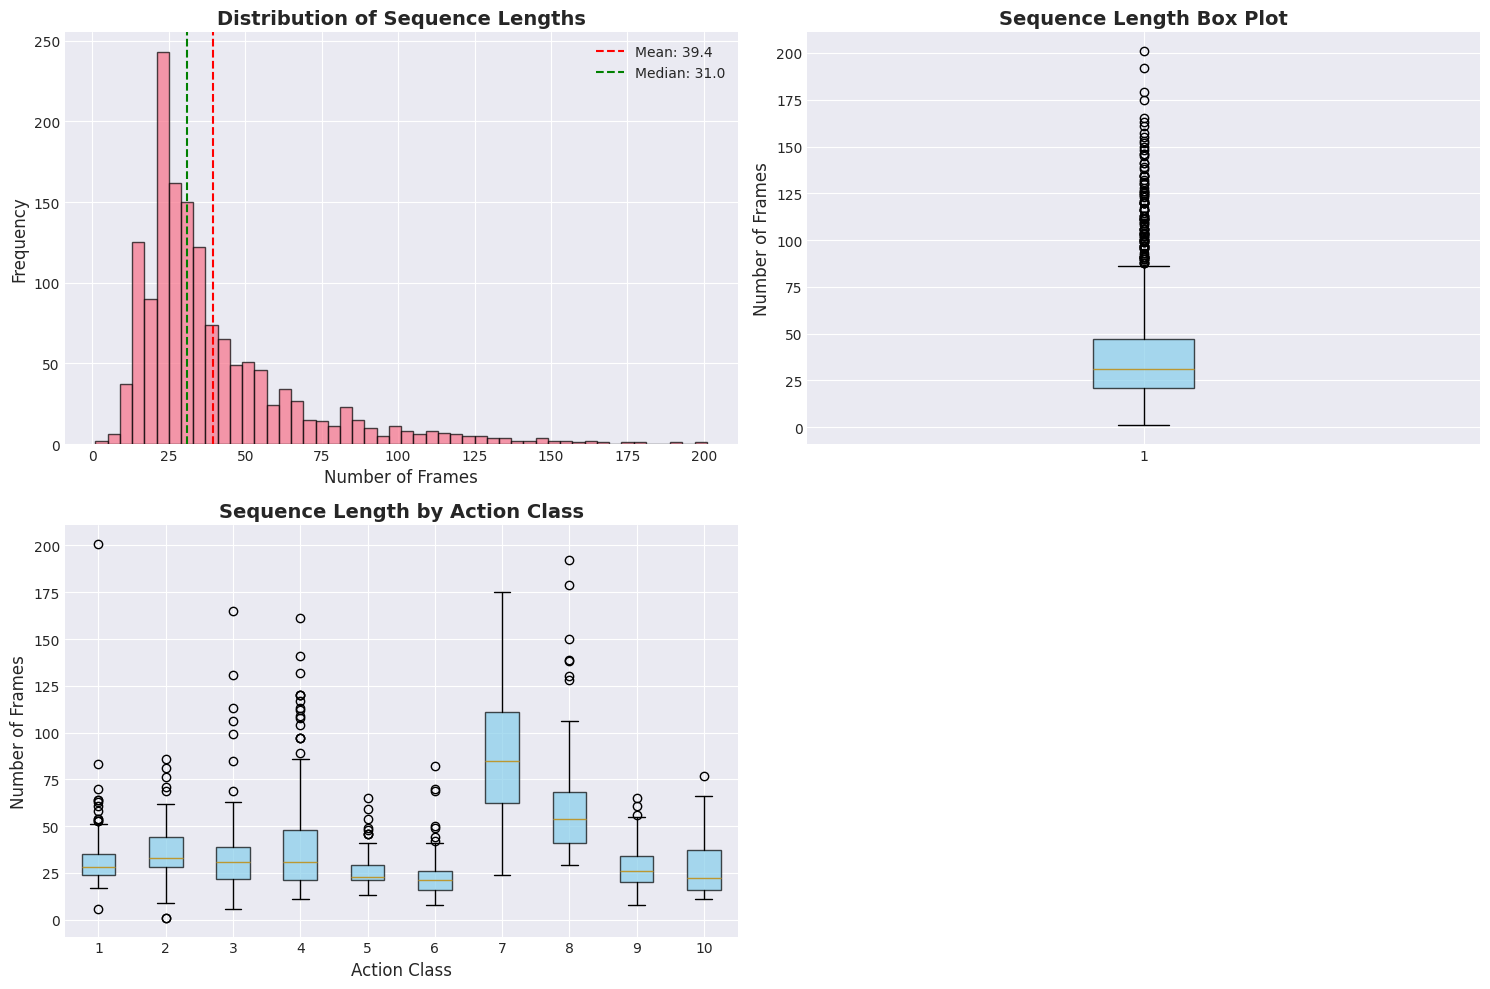

In [12]:

# Visualize
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Histogram
axes[0, 0].hist(sequence_lengths, bins=50, edgecolor='black', alpha=0.7)
axes[0, 0].set_title('Distribution of Sequence Lengths', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Number of Frames', fontsize=12)
axes[0, 0].set_ylabel('Frequency', fontsize=12)
axes[0, 0].axvline(np.mean(sequence_lengths), color='r', linestyle='--', label=f'Mean: {np.mean(sequence_lengths):.1f}')
axes[0, 0].axvline(np.median(sequence_lengths), color='g', linestyle='--', label=f'Median: {np.median(sequence_lengths):.1f}')
axes[0, 0].legend()


# Box plot
bp = axes[0, 1].boxplot(sequence_lengths, vert=True, patch_artist=True)
for patch in bp["boxes"]:
    patch.set_facecolor("skyblue")
    patch.set_alpha(0.7)
axes[0, 1].set_title("Sequence Length Box Plot", fontsize=14, fontweight="bold")
axes[0, 1].set_ylabel("Number of Frames", fontsize=12)

# By action class
action_list = sorted(df_seq["action"].unique())
box_data = [df_seq[df_seq["action"] == act]["sequence_length"].values for act in action_list]
bp = axes[1, 0].boxplot(box_data, labels=action_list, patch_artist=True)
for patch in bp["boxes"]:
    patch.set_facecolor("skyblue")
    patch.set_alpha(0.7)
axes[1, 0].set_title("Sequence Length by Action Class", fontsize=14, fontweight="bold")
axes[1, 0].set_xlabel("Action Class", fontsize=12)
axes[1, 0].set_ylabel("Number of Frames", fontsize=12)
axes[1, 0].tick_params(axis="x", rotation=0)

# Hide the unused subplot (bottom right)
axes[1, 1].axis("off")

plt.tight_layout()
plt.show()


In [21]:
df_seq['sequence_length'].describe()

count    1484.000000
mean       39.443396
std        27.800152
min         1.000000
25%        21.000000
50%        31.000000
75%        47.000000
max       201.000000
Name: sequence_length, dtype: float64

In [22]:
df_seq[df_seq['sequence_length'] == 1]

,file_name,sequence_length,action
286,a02_s09_e04_v02,1,2
287,a02_s09_e04_v03,1,2


In [13]:

# Identify outliers
Q1 = df_seq['sequence_length'].quantile(0.25)
Q3 = df_seq['sequence_length'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df_seq[(df_seq['sequence_length'] < lower_bound) | (df_seq['sequence_length'] > upper_bound)]
print(f"\nOutliers (using IQR method):")
print(f"  Lower bound: {lower_bound:.1f}")
print(f"  Upper bound: {upper_bound:.1f}")
print(f"  Number of outliers: {len(outliers)}")
print(f"  Outlier percentage: {len(outliers) / len(df_seq) * 100:.2f}%")
if len(outliers) > 0:
    print(f"\nOutlier examples:")
    print(outliers[['file_name', 'sequence_length', 'action']].head(10))


Outliers (using IQR method):
  Lower bound: -18.0
  Upper bound: 86.0
  Number of outliers: 102
  Outlier percentage: 6.87%

Outlier examples:
           file_name  sequence_length  action
109  a01_s08_e02_v01              201       1
302  a03_s01_e00_v01              106       3
305  a03_s01_e01_v01              131       3
308  a03_s01_e02_v01               99       3
311  a03_s01_e03_v01              113       3
442  a03_s10_e04_v01              165       3
443  a04_s01_e00_v01              141       4
455  a04_s01_e04_v01              120       4
472  a04_s02_e01_v02              113       4
474  a04_s02_e02_v01              120       4


Check which action class has more outliers

Outliers by Action Class:
Action  7:  64 outliers (45.07%) out of 142 total samples
Action  8:  16 outliers (11.27%) out of 142 total samples
Action  4:  16 outliers ( 9.25%) out of 173 total samples
Action  3:   5 outliers ( 3.55%) out of 141 total samples
Action  1:   1 outliers ( 0.67%) out of 150 total samples
Action class with most outliers: Action 7 (64 outliers)
Action class with highest outlier percentage: Action 7 (45.07%)


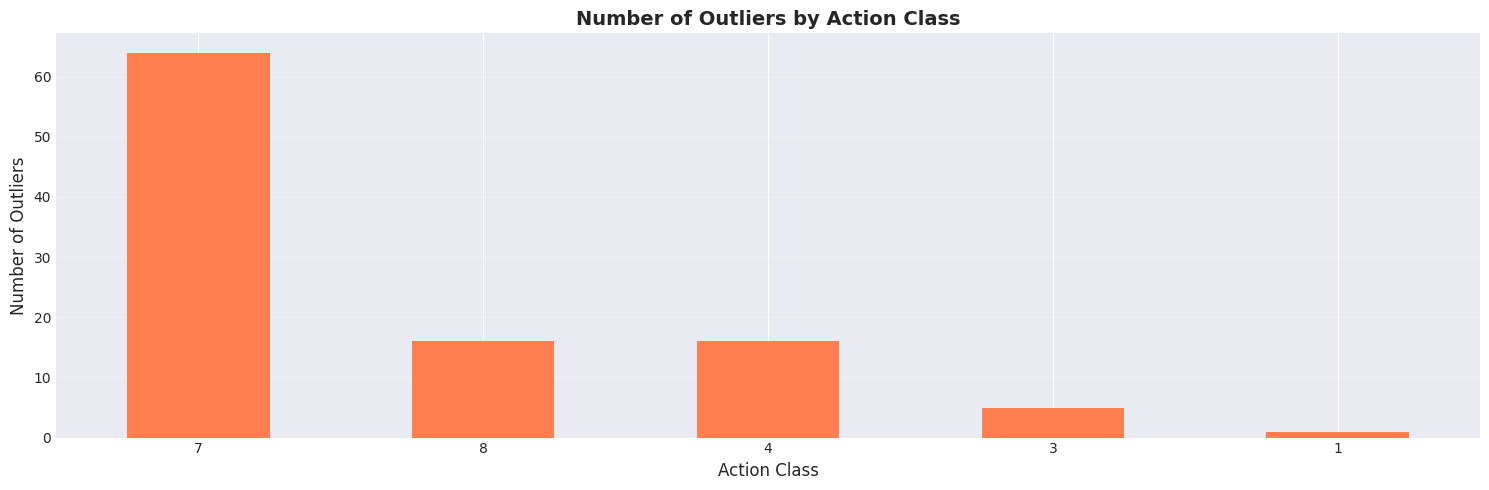

In [14]:
# Analyze outliers by action class
outlier_by_action = outliers.groupby("action").size().sort_values(ascending=False)
outlier_percent_by_action = (outlier_by_action / df_seq.groupby("action").size() * 100).sort_values(ascending=False)

print("Outliers by Action Class:")
print("=" * 50)
for action in outlier_by_action.index:
    total_samples = len(df_seq[df_seq["action"] == action])
    outlier_count = outlier_by_action[action]
    outlier_pct = outlier_percent_by_action[action]
    print(f"Action {action:2d}: {outlier_count:3d} outliers ({outlier_pct:5.2f}%) out of {total_samples:3d} total samples")

print(f"Action class with most outliers: Action {outlier_by_action.index[0]} ({outlier_by_action.iloc[0]} outliers)")
print(f"Action class with highest outlier percentage: Action {outlier_percent_by_action.index[0]} ({outlier_percent_by_action.iloc[0]:.2f}%)")

# Visualize
fig, axes = plt.subplots(figsize=(15, 5))

# Bar plot: Count of outliers
outlier_by_action.plot(kind="bar", ax=axes, color="coral")
axes.set_title("Number of Outliers by Action Class", fontsize=14, fontweight="bold")
axes.set_xlabel("Action Class", fontsize=12)
axes.set_ylabel("Number of Outliers", fontsize=12)
axes.set_xticklabels(outlier_by_action.index, rotation=0)
axes.grid(True, alpha=0.3, axis="y")

# # Bar plot: Percentage of outliers
# outlier_percent_by_action.plot(kind="bar", ax=axes[1], color="salmon")
# axes[1].set_title("Outlier Percentage by Action Class", fontsize=14, fontweight="bold")
# axes[1].set_xlabel("Action Class", fontsize=12)
# axes[1].set_ylabel("Outlier Percentage (%)", fontsize=12)
# axes[1].set_xticklabels(outlier_percent_by_action.index, rotation=0)
# axes[1].grid(True, alpha=0.3, axis="y")

plt.tight_layout()
plt.show()


## 4. Spatial (Skeleton) Characteristics

### 4.1 Skeleton Structure

In [15]:
from mpl_toolkits.mplot3d import Axes3D

In [16]:
# Load bone structure from feeder
# NW-UCLA bone pairs: (child_joint, parent_joint) - 1-indexed
ucla_bone_pairs = [(1, 2), (2, 3), (3, 3), (4, 3), (5, 3), (6, 5), (7, 6), (8, 7), (9, 3), (10, 9), 
                    (11, 10), (12, 11), (13, 1), (14, 13), (15, 14), (16, 15), (17, 1), (18, 17), 
                    (19, 18), (20, 19)]

print("NW-UCLA Skeleton Structure:")
print(f"  Number of joints: 20")
print(f"  Number of bones: {len(ucla_bone_pairs)}")
print(f"\nBone Connectivity (child -> parent):")
for i, (child, parent) in enumerate(ucla_bone_pairs, 1):
    print(f"  Bone {i:2d}: Joint {child:2d} -> Joint {parent:2d}")

NW-UCLA Skeleton Structure:
  Number of joints: 20
  Number of bones: 20

Bone Connectivity (child -> parent):
  Bone  1: Joint  1 -> Joint  2
  Bone  2: Joint  2 -> Joint  3
  Bone  3: Joint  3 -> Joint  3
  Bone  4: Joint  4 -> Joint  3
  Bone  5: Joint  5 -> Joint  3
  Bone  6: Joint  6 -> Joint  5
  Bone  7: Joint  7 -> Joint  6
  Bone  8: Joint  8 -> Joint  7
  Bone  9: Joint  9 -> Joint  3
  Bone 10: Joint 10 -> Joint  9
  Bone 11: Joint 11 -> Joint 10
  Bone 12: Joint 12 -> Joint 11
  Bone 13: Joint 13 -> Joint  1
  Bone 14: Joint 14 -> Joint 13
  Bone 15: Joint 15 -> Joint 14
  Bone 16: Joint 16 -> Joint 15
  Bone 17: Joint 17 -> Joint  1
  Bone 18: Joint 18 -> Joint 17
  Bone 19: Joint 19 -> Joint 18
  Bone 20: Joint 20 -> Joint 19


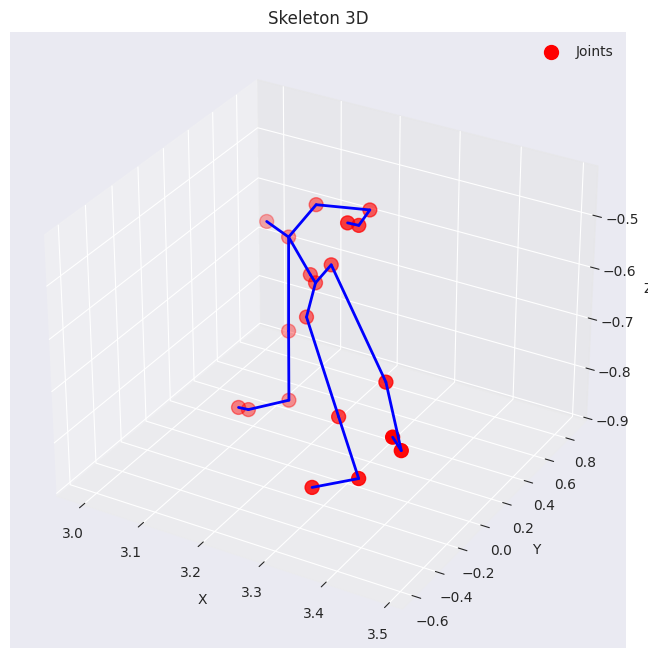

In [17]:
# Visualize a sample skeleton in 3D
def plot_skeleton_3d(skeleton, bone_pairs, ax=None, title="Skeleton 3D"):
    """
    Plot skeleton in 3D space
    skeleton: (V, 3) array of joint coordinates
    bone_pairs: list of (child, parent) tuples
    """
    if ax is None:
        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111, projection='3d')
    
    # Plot joints
    ax.scatter(
        skeleton[:, 2], 
        skeleton[:, 1], 
        skeleton[:, 0], 
        s=100, c='red', marker='o', label='Joints'
    )
    
    # Plot bones
    for child, parent in bone_pairs:
        if child != parent:
            child_idx = child - 1  # Convert to 0-indexed
            parent_idx = parent - 1
            if child_idx < len(skeleton) and parent_idx < len(skeleton):
                ax.plot(
                    [skeleton[parent_idx, 2], skeleton[child_idx, 2]],
                    [skeleton[parent_idx, 1], skeleton[child_idx, 1]],
                    [skeleton[parent_idx, 0], skeleton[child_idx, 0]],
                    'b-', linewidth=2)
    
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title(title)
    ax.legend()
    return ax

# Example usage:
# Load a sample skeleton
with open(all_json_files[0], 'r') as f:
    data = json.load(f)
skeleton_array = np.array(data['skeletons'])
skeleton_at_t = skeleton_array[2]
plot_skeleton_3d(skeleton_at_t, ucla_bone_pairs)
plt.show()

### 4.2 Joint Coordinate Analysis

In [18]:
def analyze_joint_coordinates(filepaths, max_samples=50):
    """Analyze joint coordinate statistics"""
    all_coords = []
    joint_stats = []
    
    sample_files = filepaths[:max_samples] if len(filepaths) > max_samples else filepaths
    
    for f in sample_files:
        # print(f)
        # print(type(f))
        try:
            with open(f, 'r') as file:
                data = json.load(file)
            skeletons = np.array(data['skeletons'])  # Shape: (T, V, 3)
            all_coords.append(skeletons)    
            
            # Per-joint statistics
            for joint_idx in range(skeletons.shape[1]):
                joint_coords = skeletons[:, joint_idx, :]  # (T, 3)
                joint_stats.append({
                    'file': Path(f).stem,
                    'joint': joint_idx,
                    'mean_x': joint_coords[:, 0].mean(),
                    'mean_y': joint_coords[:, 1].mean(),
                    'mean_z': joint_coords[:, 2].mean(),
                    'std_x': joint_coords[:, 0].std(),
                    'std_y': joint_coords[:, 1].std(),
                    'std_z': joint_coords[:, 2].std(),
                    'range_x': joint_coords[:, 0].max() - joint_coords[:, 0].min(),
                    'range_y': joint_coords[:, 1].max() - joint_coords[:, 1].min(),
                    'range_z': joint_coords[:, 2].max() - joint_coords[:, 2].min(),
                })
        except Exception as e:
            print(f"Error processing {f}: {e}")
    
    all_coords_array = np.concatenate(all_coords, axis=0)  # (T_total, V, 3)
    df_joint_stats = pd.DataFrame(joint_stats)
    
    return all_coords_array, df_joint_stats

In [19]:
# test function
coords_array, df_joint = analyze_joint_coordinates(all_json_files, max_samples=1)

Analyzing joint coordinates...

Overall Coordinate Statistics:
  Shape: (3222, 20, 3)
  Min (X, Y, Z): (-1.65, -1.25, 1.35)
  Max (X, Y, Z): (2.10, 1.40, 3.99)
  Mean (X, Y, Z): (-0.13, -0.01, 2.73)
  Std (X, Y, Z): (0.49, 0.44, 0.38)

Per-Joint Average Statistics:
       mean_x  mean_y  mean_z  std_x  std_y  std_z  range_x  range_y  range_z
joint                                                                        
0       -0.14    0.17    2.71   0.22   0.15   0.17     0.82     0.49     0.61
1       -0.14    0.22    2.71   0.22   0.16   0.17     0.82     0.51     0.61
2       -0.12    0.51    2.65   0.23   0.21   0.18     0.84     0.66     0.62
3       -0.11    0.64    2.63   0.24   0.24   0.18     0.84     0.74     0.62
4       -0.22    0.44    2.63   0.23   0.20   0.17     0.84     0.61     0.60
5       -0.28    0.24    2.62   0.23   0.16   0.18     0.85     0.52     0.63
6       -0.28    0.04    2.66   0.25   0.16   0.19     0.90     0.54     0.68
7       -0.28   -0.03    2.68   

AttributeError: 'numpy.ndarray' object has no attribute 'barh'

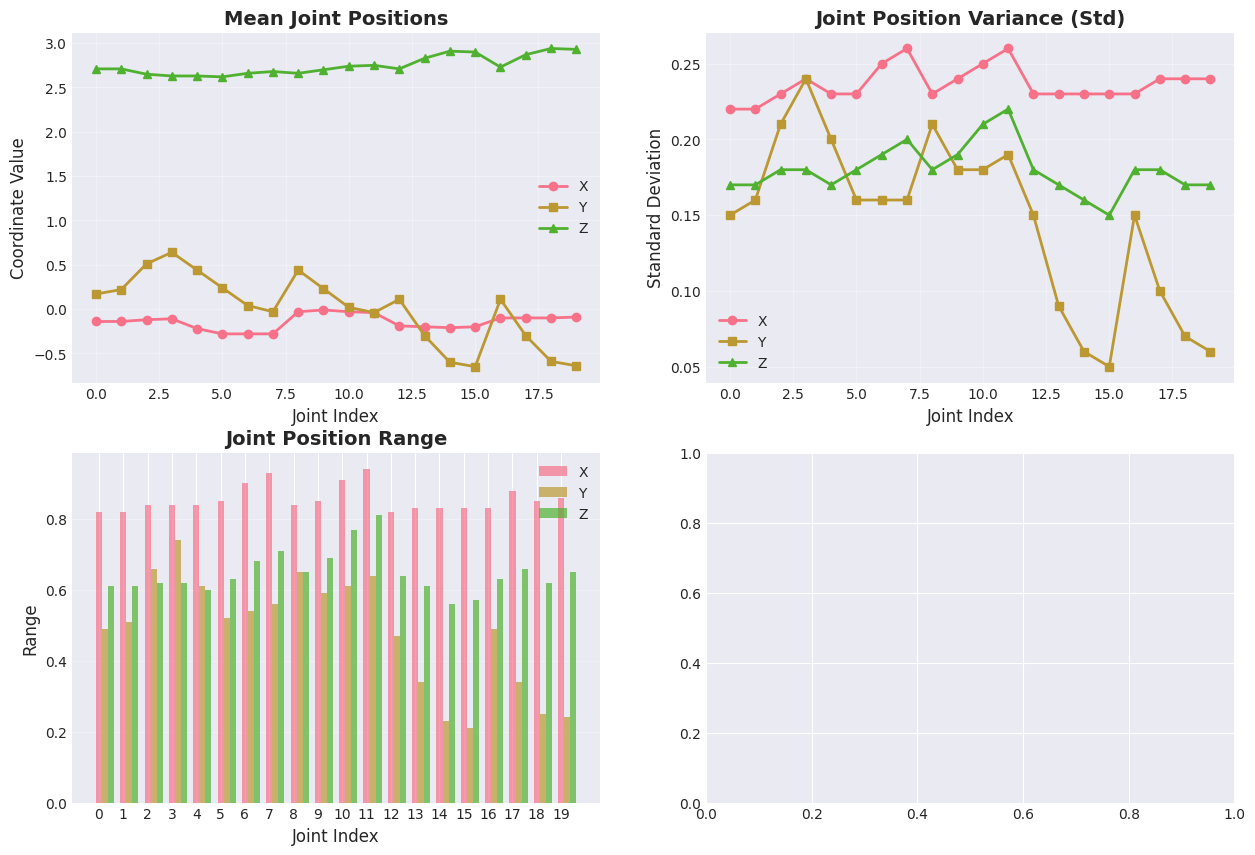

In [20]:
# Analyze joint coordinates across multiple samples

print("Analyzing joint coordinates...")
coords_array, df_joint = analyze_joint_coordinates(all_json_files, max_samples=100)

print("\nOverall Coordinate Statistics:")
print(f"  Shape: {coords_array.shape}")
print(f"  Min (X, Y, Z): ({coords_array[:, :, 0].min():.2f}, {coords_array[:, :, 1].min():.2f}, {coords_array[:, :, 2].min():.2f})")
print(f"  Max (X, Y, Z): ({coords_array[:, :, 0].max():.2f}, {coords_array[:, :, 1].max():.2f}, {coords_array[:, :, 2].max():.2f})")
print(f"  Mean (X, Y, Z): ({coords_array[:, :, 0].mean():.2f}, {coords_array[:, :, 1].mean():.2f}, {coords_array[:, :, 2].mean():.2f})")
print(f"  Std (X, Y, Z): ({coords_array[:, :, 0].std():.2f}, {coords_array[:, :, 1].std():.2f}, {coords_array[:, :, 2].std():.2f})")

# Per-joint statistics
joint_summary = df_joint.groupby('joint').agg({
    'mean_x': 'mean', 'mean_y': 'mean', 'mean_z': 'mean',
    'std_x': 'mean', 'std_y': 'mean', 'std_z': 'mean',
    'range_x': 'mean', 'range_y': 'mean', 'range_z': 'mean'
}).round(2)

print("\nPer-Joint Average Statistics:")
print(joint_summary.head(10))

# Visualize joint positions
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Mean position per joint
joints = range(20)
axes[0, 0].plot(joints, joint_summary['mean_x'], 'o-', label='X', linewidth=2, markersize=6)
axes[0, 0].plot(joints, joint_summary['mean_y'], 's-', label='Y', linewidth=2, markersize=6)
axes[0, 0].plot(joints, joint_summary['mean_z'], '^-', label='Z', linewidth=2, markersize=6)
axes[0, 0].set_title('Mean Joint Positions', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Joint Index', fontsize=12)
axes[0, 0].set_ylabel('Coordinate Value', fontsize=12)
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Variance per joint
axes[0, 1].plot(joints, joint_summary['std_x'], 'o-', label='X', linewidth=2, markersize=6)
axes[0, 1].plot(joints, joint_summary['std_y'], 's-', label='Y', linewidth=2, markersize=6)
axes[0, 1].plot(joints, joint_summary['std_z'], '^-', label='Z', linewidth=2, markersize=6)
axes[0, 1].set_title('Joint Position Variance (Std)', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Joint Index', fontsize=12)
axes[0, 1].set_ylabel('Standard Deviation', fontsize=12)
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Range per joint
axes[1, 0].bar(joints, joint_summary['range_x'], alpha=0.7, label='X', width=0.25)
axes[1, 0].bar([j + 0.25 for j in joints], joint_summary['range_y'], alpha=0.7, label='Y', width=0.25)
axes[1, 0].bar([j + 0.5 for j in joints], joint_summary['range_z'], alpha=0.7, label='Z', width=0.25)
axes[1, 0].set_title('Joint Position Range', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Joint Index', fontsize=12)
axes[1, 0].set_ylabel('Range', fontsize=12)
axes[1, 0].legend()
axes[1, 0].set_xticks(joints)
axes[1, 0].grid(True, alpha=0.3, axis='y')

# Most/least variable joints
total_variance = joint_summary[['std_x', 'std_y', 'std_z']].mean(axis=1)
most_variable = total_variance.nlargest(5).index.tolist()
least_variable = total_variance.nsmallest(5).index.tolist()

axes[1,].barh(range(5), total_variance[most_variable].values, color='coral', alpha=0.7)
axes[1,].set_yticks(range(5))
axes[1,].set_yticklabels([f'Joint {j}' for j in most_variable])
axes[1,].set_title('Top 5 Most Variable Joints', fontsize=14, fontweight='bold')
axes[1,].set_xlabel('Average Standard Deviation', fontsize=12)
axes[1,].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

print(f"\nMost variable joints: {most_variable}")
print(f"Least variable joints: {least_variable}")

### 4.3 Spatial Relationships

#### Bone Length Analysis

Computing bone statistics...

Bone Length Statistics:
     bone_length                      bone_x bone_y bone_z
            mean    std    min    max   mean   mean   mean
bone                                                      
0          0.071  0.011  0.013  0.113 -0.003 -0.058  0.007
1          0.340  0.053  0.040  0.516 -0.015 -0.292  0.058
2          0.000  0.000  0.000  0.000  0.000  0.000  0.000
3          0.198  0.026  0.114  0.315  0.012  0.130 -0.025
4          0.193  0.050  0.043  0.529 -0.100 -0.074 -0.023
5          0.269  0.036  0.136  0.391 -0.058 -0.204 -0.000
6          0.251  0.036  0.130  0.385 -0.001 -0.204  0.041
7          0.084  0.022  0.004  0.283 -0.001 -0.065  0.015
8          0.200  0.054  0.047  0.483  0.098 -0.075  0.019
9          0.268  0.037  0.094  0.413  0.017 -0.210  0.035
10         0.254  0.037  0.112  0.385 -0.014 -0.206  0.036
11         0.085  0.023  0.016  0.320 -0.003 -0.067  0.013
12         0.090  0.035  0.008  0.340 -0.044 -0.053  0.003
13

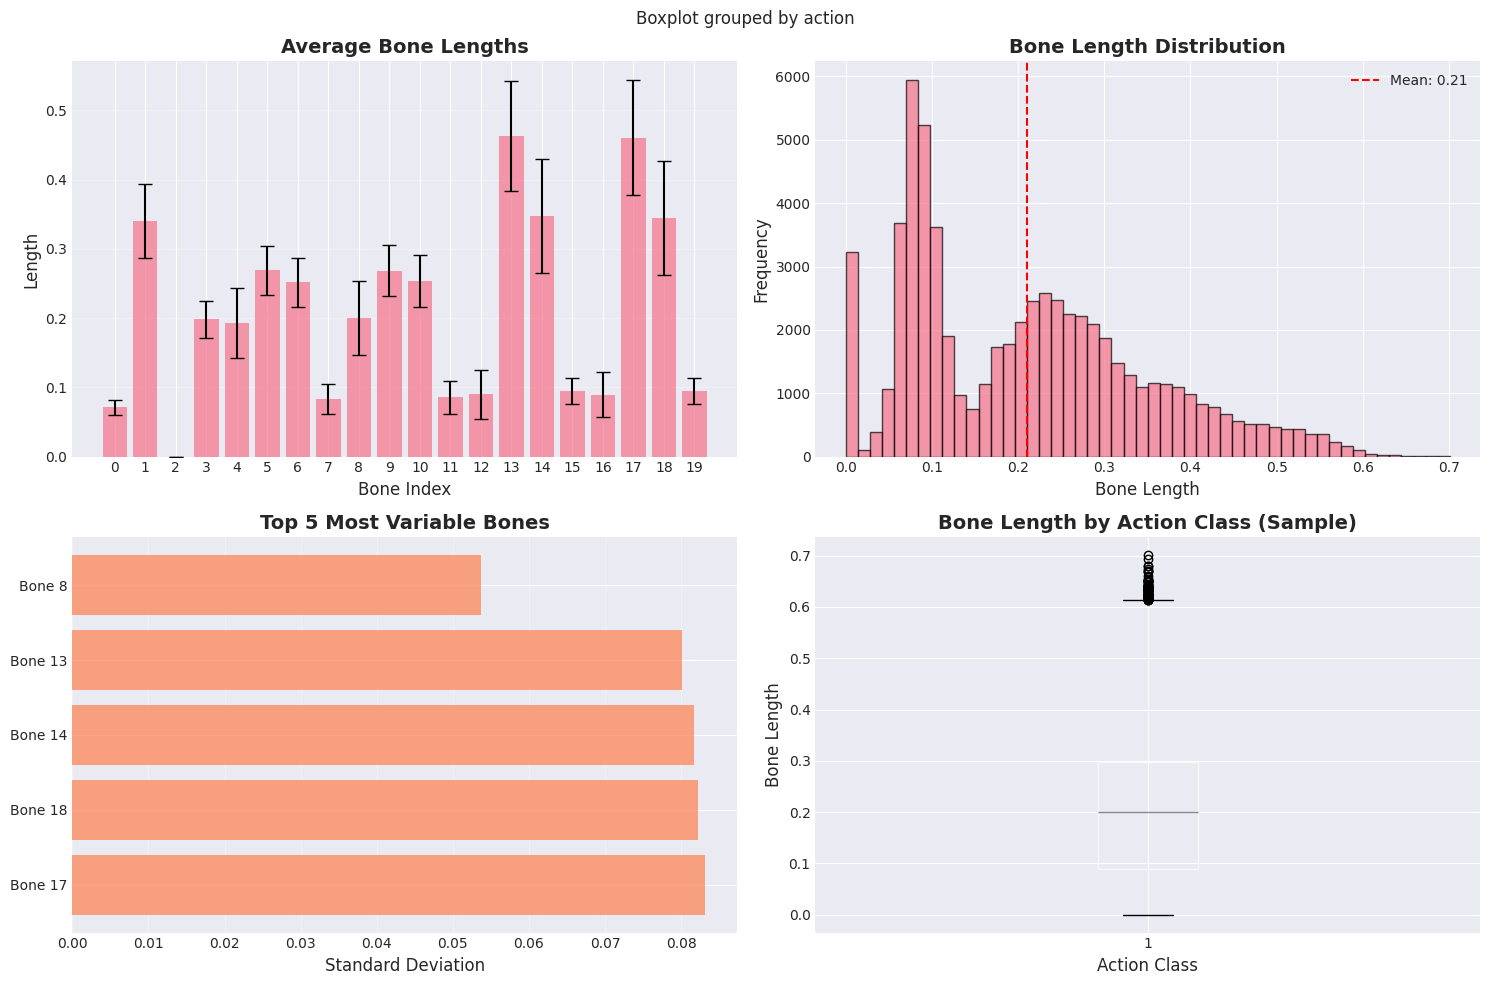


Most variable bones: [17, 18, 14, 13, 8]
Least variable bones: [2, 0, 19, 15, 7]


In [ ]:
# Compute bone vectors and lengths
def compute_bone_statistics(filepaths, max_samples=50):
    """Compute bone vector statistics"""
    bone_stats = []
    
    sample_files = filepaths[:max_samples] if len(filepaths) > max_samples else filepaths
    
    for f in sample_files:
        try:
            with open(f, 'r') as file:
                data = json.load(file)
            skeletons = np.array(data['skeletons'])  # (T, V, 3)
            
            # Compute bone vectors for each frame
            for t in range(skeletons.shape[0]):
                frame = skeletons[t]  # (V, 3)
                
                for bone_idx, (child, parent) in enumerate(ucla_bone_pairs):
                    child_idx = child - 1  # Convert to 0-indexed
                    parent_idx = parent - 1
                    
                    if child_idx < len(frame) and parent_idx < len(frame):
                        bone_vector = frame[child_idx] - frame[parent_idx]
                        bone_length = np.linalg.norm(bone_vector)
                        
                        bone_stats.append({
                            'file': Path(f).stem,
                            'frame': t,
                            'bone': bone_idx,
                            'bone_length': bone_length,
                            'bone_x': bone_vector[0],
                            'bone_y': bone_vector[1],
                            'bone_z': bone_vector[2],
                        })
        except Exception as e:
            print(f"Error processing {f}: {e}")
    
    return pd.DataFrame(bone_stats)

print("Computing bone statistics...")
df_bones = compute_bone_statistics(all_json_files, max_samples=100)

bone_summary = df_bones.groupby('bone').agg({
    'bone_length': ['mean', 'std', 'min', 'max'],
    'bone_x': 'mean',
    'bone_y': 'mean',
    'bone_z': 'mean'
}).round(3)

print("\nBone Length Statistics:")
print(bone_summary)

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(15, 10))

bones = range(len(ucla_bone_pairs))
mean_lengths = df_bones.groupby('bone')['bone_length'].mean()
std_lengths = df_bones.groupby('bone')['bone_length'].std()

axes[0, 0].bar(bones, mean_lengths, yerr=std_lengths, alpha=0.7, capsize=5)
axes[0, 0].set_title('Average Bone Lengths', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Bone Index', fontsize=12)
axes[0, 0].set_ylabel('Length', fontsize=12)
axes[0, 0].set_xticks(bones)
axes[0, 0].grid(True, alpha=0.3, axis='y')

# Bone length distribution
axes[0, 1].hist(df_bones['bone_length'], bins=50, edgecolor='black', alpha=0.7)
axes[0, 1].set_title('Bone Length Distribution', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Bone Length', fontsize=12)
axes[0, 1].set_ylabel('Frequency', fontsize=12)
axes[0, 1].axvline(df_bones['bone_length'].mean(), color='r', linestyle='--', 
                    label=f'Mean: {df_bones["bone_length"].mean():.2f}')
axes[0, 1].legend()

# Most/least variable bones
bone_variance = df_bones.groupby('bone')['bone_length'].std()
most_variable_bones = bone_variance.nlargest(5).index.tolist()
least_variable_bones = bone_variance.nsmallest(5).index.tolist()

axes[1, 0].barh(range(5), bone_variance[most_variable_bones].values, color='coral', alpha=0.7)
axes[1, 0].set_yticks(range(5))
axes[1, 0].set_yticklabels([f'Bone {b}' for b in most_variable_bones])
axes[1, 0].set_title('Top 5 Most Variable Bones', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Standard Deviation', fontsize=12)
axes[1, 0].grid(True, alpha=0.3, axis='x')

# Bone length by action (sample)
sample_actions = df_files['action'].unique()[:5]
df_bones_with_action = df_bones.merge(
    df_files[['file_name', 'action']], 
    left_on='file', 
    right_on='file_name', 
    how='left'
)
df_bones_with_action = df_bones_with_action[df_bones_with_action['action'].isin(sample_actions)]

if len(df_bones_with_action) > 0:
    df_bones_with_action.boxplot(column='bone_length', by='action', ax=axes[1])
    axes[1].set_title('Bone Length by Action Class (Sample)', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Action Class', fontsize=12)
    axes[1].set_ylabel('Bone Length', fontsize=12)

plt.tight_layout()
plt.show()

print(f"\nMost variable bones: {most_variable_bones}")
print(f"Least variable bones: {least_variable_bones}")

## 5. Motion Statistics

### 5.1 Velocity Analysis

Computing velocity statistics...

Velocity Statistics:
count    62440.000000
mean         0.075273
std          0.077190
min          0.000040
25%          0.028111
50%          0.061499
75%          0.100025
max          2.208618
Name: velocity_magnitude, dtype: float64

Per-Joint Velocity Statistics:
      velocity_magnitude              
                    mean    std    max
joint                                 
0                  0.065  0.059  1.822
1                  0.066  0.059  1.833
2                  0.080  0.068  1.802
3                  0.085  0.068  1.713
4                  0.078  0.065  1.525
5                  0.075  0.069  1.752
6                  0.083  0.077  1.978
7                  0.088  0.084  2.005
8                  0.080  0.069  1.821
9                  0.083  0.076  1.978


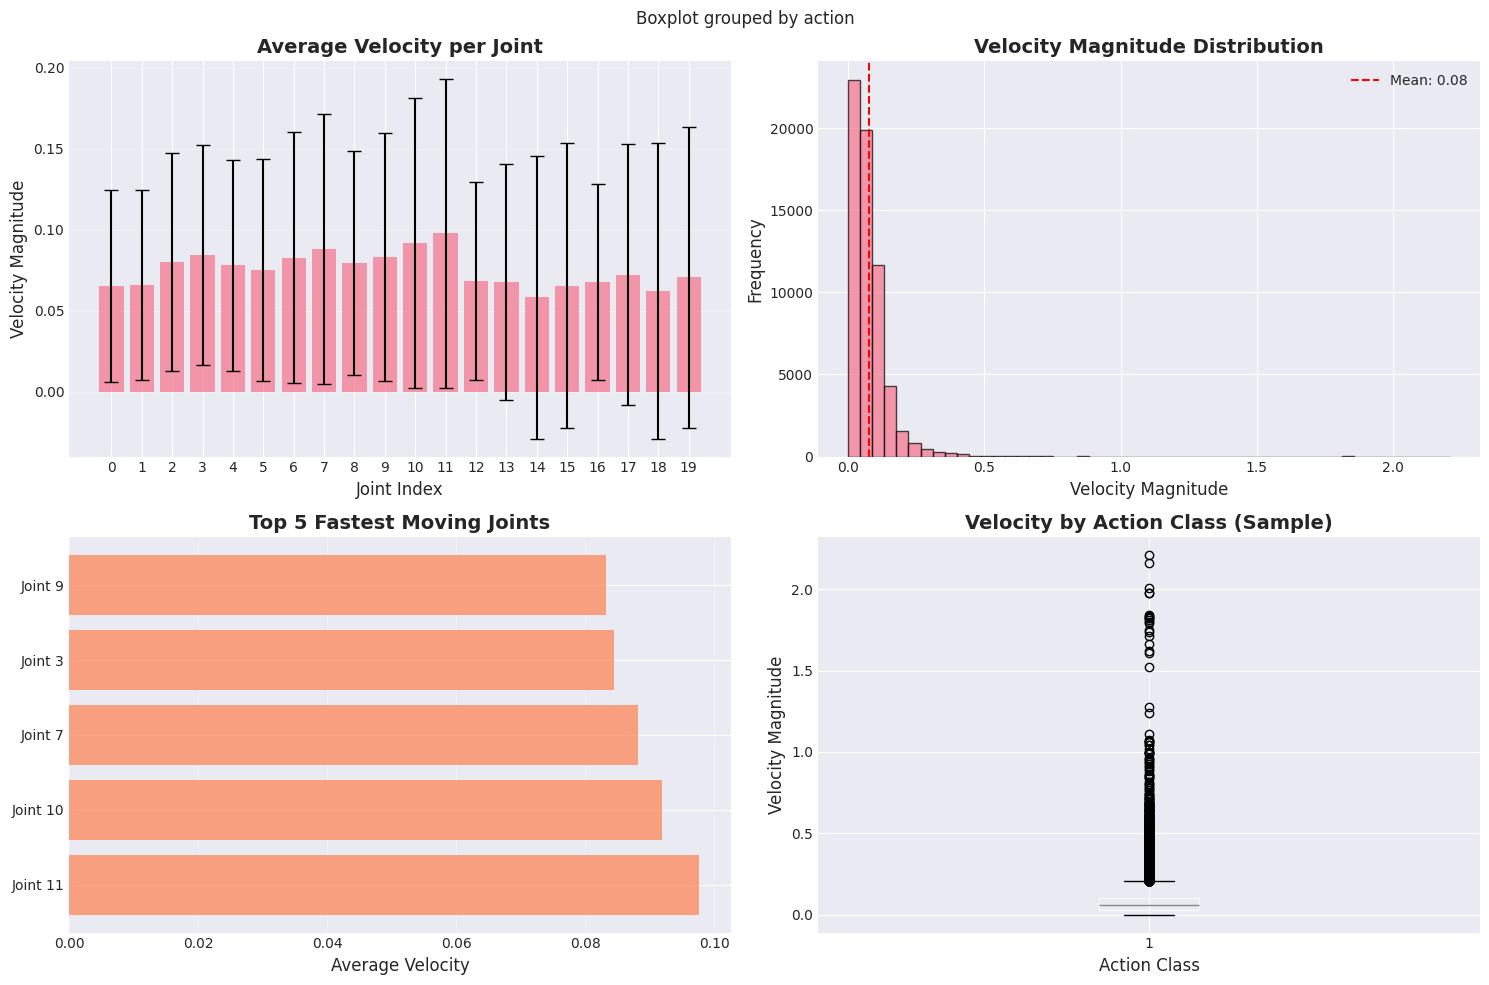


Fastest moving joints: [11, 10, 7, 3, 9]
Slowest moving joints: [14, 18, 15, 0, 1]


In [ ]:
# Compute velocity (frame-to-frame differences)
def compute_velocity_statistics(filepaths, max_samples=50):
    """Compute velocity statistics"""
    velocity_stats = []
    
    sample_files = filepaths[:max_samples] if len(filepaths) > max_samples else filepaths
    
    for f in sample_files:
        try:
            with open(f, 'r') as file:
                data = json.load(file)
            skeletons = np.array(data['skeletons'])  # (T, V, 3)
            
            # Compute velocities
            velocities = np.diff(skeletons, axis=0)  # (T-1, V, 3)
            velocity_magnitudes = np.linalg.norm(velocities, axis=2)  # (T-1, V)
            
            for t in range(velocities.shape[0]):
                for joint_idx in range(velocities.shape[1]):
                    velocity_stats.append({
                        'file': Path(f).stem,
                        'frame': t,
                        'joint': joint_idx,
                        'velocity_magnitude': velocity_magnitudes[t, joint_idx],
                        'velocity_x': velocities[t, joint_idx, 0],
                        'velocity_y': velocities[t, joint_idx, 1],
                        'velocity_z': velocities[t, joint_idx, 2],
                    })
        except Exception as e:
            print(f"Error processing {f}: {e}")
    
    return pd.DataFrame(velocity_stats)

print("Computing velocity statistics...")
df_velocity = compute_velocity_statistics(all_json_files, max_samples=100)

print("\nVelocity Statistics:")
print(df_velocity['velocity_magnitude'].describe())

# Per-joint velocity statistics
joint_velocity_summary = df_velocity.groupby('joint').agg({
    'velocity_magnitude': ['mean', 'std', 'max'],
}).round(3)

print("\nPer-Joint Velocity Statistics:")
print(joint_velocity_summary.head(10))

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(15, 10))

joints = range(20)
mean_velocities = df_velocity.groupby('joint')['velocity_magnitude'].mean()
std_velocities = df_velocity.groupby('joint')['velocity_magnitude'].std()

axes[0, 0].bar(joints, mean_velocities, yerr=std_velocities, alpha=0.7, capsize=5)
axes[0, 0].set_title('Average Velocity per Joint', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Joint Index', fontsize=12)
axes[0, 0].set_ylabel('Velocity Magnitude', fontsize=12)
axes[0, 0].set_xticks(joints)
axes[0, 0].grid(True, alpha=0.3, axis='y')

# Velocity distribution
axes[0, 1].hist(df_velocity['velocity_magnitude'], bins=50, edgecolor='black', alpha=0.7)
axes[0, 1].set_title('Velocity Magnitude Distribution', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Velocity Magnitude', fontsize=12)
axes[0, 1].set_ylabel('Frequency', fontsize=12)
axes[0, 1].axvline(df_velocity['velocity_magnitude'].mean(), color='r', linestyle='--', 
                    label=f'Mean: {df_velocity["velocity_magnitude"].mean():.2f}')
axes[0, 1].legend()

# Fastest/slowest moving joints
fastest_joints = mean_velocities.nlargest(5).index.tolist()
slowest_joints = mean_velocities.nsmallest(5).index.tolist()

axes[1, 0].barh(range(5), mean_velocities[fastest_joints].values, color='coral', alpha=0.7)
axes[1, 0].set_yticks(range(5))
axes[1, 0].set_yticklabels([f'Joint {j}' for j in fastest_joints])
axes[1, 0].set_title('Top 5 Fastest Moving Joints', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Average Velocity', fontsize=12)
axes[1, 0].grid(True, alpha=0.3, axis='x')

# Velocity by action (sample)
df_velocity_with_action = df_velocity.merge(
    df_files[['file_name', 'action']], 
    left_on='file', 
    right_on='file_name', 
    how='left'
)
sample_actions = df_files['action'].unique()[:5]
df_velocity_with_action = df_velocity_with_action[df_velocity_with_action['action'].isin(sample_actions)]

if len(df_velocity_with_action) > 0:
    df_velocity_with_action.boxplot(column='velocity_magnitude', by='action', ax=axes[1])
    axes[1].set_title('Velocity by Action Class (Sample)', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Action Class', fontsize=12)
    axes[1].set_ylabel('Velocity Magnitude', fontsize=12)

plt.tight_layout()
plt.show()

print(f"\nFastest moving joints: {fastest_joints}")
print(f"Slowest moving joints: {slowest_joints}")

## 6. Missing / Noise Analysis

### 6.1 Missing Data Detection

Checking for missing data...

Missing Data Statistics:
       num_frames  num_joints  zero_coords  zero_coords_pct  nan_coords  \
count  200.000000       200.0        200.0            200.0       200.0   
mean    35.665000        20.0          0.0              0.0         0.0   
std     17.912483         0.0          0.0              0.0         0.0   
min      6.000000        20.0          0.0              0.0         0.0   
25%     26.000000        20.0          0.0              0.0         0.0   
50%     31.000000        20.0          0.0              0.0         0.0   
75%     42.000000        20.0          0.0              0.0         0.0   
max    201.000000        20.0          0.0              0.0         0.0   

       inf_coords  zero_frames  zero_joints  
count       200.0        200.0        200.0  
mean          0.0          0.0          0.0  
std           0.0          0.0          0.0  
min           0.0          0.0          0.0  
25%           0.0          0.0         

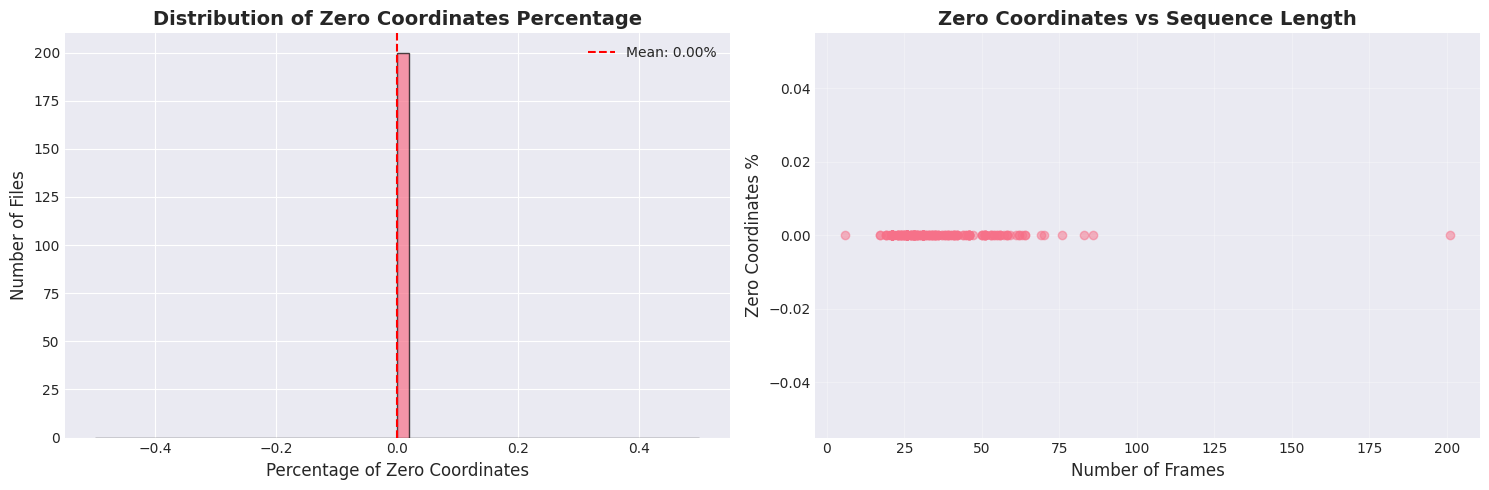


Data Quality Summary:
  Files with zero coordinates: 0
  Files with NaN values: 0
  Files with Inf values: 0
  Files with zero frames: 0
  Files with zero joints: 0


In [ ]:
# Check for missing data (zero coordinates, NaN values)
def check_missing_data(filepaths, max_samples=100):
    """Check for missing or invalid data"""
    missing_stats = []
    
    sample_files = filepaths[:max_samples] if len(filepaths) > max_samples else filepaths
    
    for f in sample_files:
        try:
            with open(f, 'r') as file:
                data = json.load(file)
            skeletons = np.array(data['skeletons'])  # (T, V, 3)
            
            # Check for zeros, NaNs, Infs
            num_frames = skeletons.shape[0]
            num_joints = skeletons.shape[1]
            total_coords = num_frames * num_joints * 3
            
            zero_coords = np.sum(skeletons == 0)
            nan_coords = np.sum(np.isnan(skeletons))
            inf_coords = np.sum(np.isinf(skeletons))
            
            # Check for completely zero frames
            zero_frames = np.sum(np.all(skeletons == 0, axis=(1, 2)))
            
            # Check for completely zero joints
            zero_joints = np.sum(np.all(skeletons == 0, axis=(0, 2)))
            
            missing_stats.append({
                'file': Path(f).stem,
                'num_frames': num_frames,
                'num_joints': num_joints,
                'zero_coords': zero_coords,
                'zero_coords_pct': zero_coords / total_coords * 100,
                'nan_coords': nan_coords,
                'inf_coords': inf_coords,
                'zero_frames': zero_frames,
                'zero_joints': zero_joints,
            })
        except Exception as e:
            print(f"Error processing {f}: {e}")
    
    return pd.DataFrame(missing_stats)

print("Checking for missing data...")
df_missing = check_missing_data(all_json_files, max_samples=200)

print("\nMissing Data Statistics:")
print(df_missing.describe())

# Identify files with significant missing data
threshold = 5.0  # 5% threshold
files_with_missing = df_missing[df_missing['zero_coords_pct'] > threshold]

print(f"\nFiles with >{threshold}% zero coordinates: {len(files_with_missing)}")
if len(files_with_missing) > 0:
    print("\nExamples:")
    print(files_with_missing[['file', 'zero_coords_pct', 'zero_frames', 'zero_joints']].head(10))

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].hist(df_missing['zero_coords_pct'], bins=50, edgecolor='black', alpha=0.7)
axes[0].set_title('Distribution of Zero Coordinates Percentage', fontsize=14, fontweight='bold')
action_counts.plot(kind='bar', ax=axes[0], color='skyblue')
axes[0].set_title('Action Class Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Percentage of Zero Coordinates', fontsize=12)
axes[0].set_ylabel('Number of Files', fontsize=12)
axes[0].axvline(df_missing['zero_coords_pct'].mean(), color='r', linestyle='--', 
                label=f'Mean: {df_missing["zero_coords_pct"].mean():.2f}%')
axes[0].legend()

axes[1].scatter(df_missing['num_frames'], df_missing['zero_coords_pct'], alpha=0.5)
axes[1].set_title('Zero Coordinates vs Sequence Length', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Number of Frames', fontsize=12)
axes[1].set_ylabel('Zero Coordinates %', fontsize=12)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nData Quality Summary:")
print(f"  Files with zero coordinates: {len(df_missing[df_missing['zero_coords'] > 0])}")
print(f"  Files with NaN values: {len(df_missing[df_missing['nan_coords'] > 0])}")
print(f"  Files with Inf values: {len(df_missing[df_missing['inf_coords'] > 0])}")
print(f"  Files with zero frames: {len(df_missing[df_missing['zero_frames'] > 0])}")
print(f"  Files with zero joints: {len(df_missing[df_missing['zero_joints'] > 0])}")

## 7. Viewpoint & Subject Variations

### 7.1 Viewpoint Analysis

Viewpoint Distribution:
view
1    516
2    504
3    464
Name: count, dtype: int64

Viewpoint Distribution by Split:
split  train  val
view             
1        516    0
2        504    0
3          0  464

Viewpoint Distribution by Action (sample):
action  1   2   3   4   5   6   8   9   11  12
view                                          
1       53  52  51  64  50  52  49  50  49  46
2       49  50  45  60  51  50  50  49  49  51
3       48  50  45  49  47  47  43  43  47  45


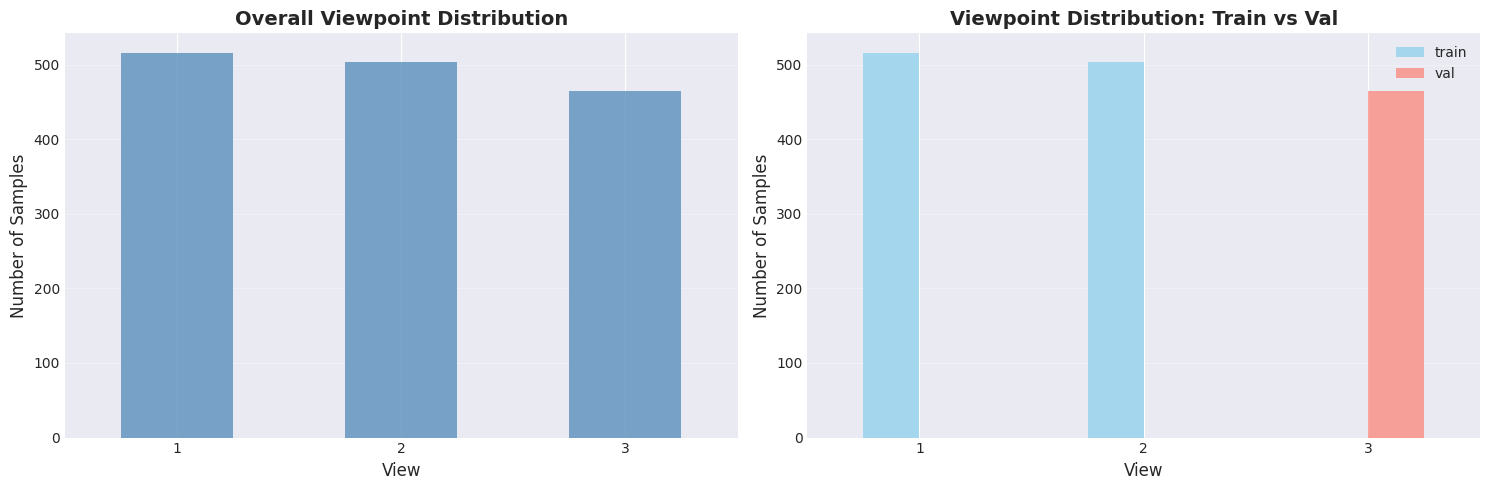

In [ ]:
# Analyze viewpoint distribution
view_distribution = df_files['view'].value_counts().sort_index()
print("Viewpoint Distribution:")
print(view_distribution)

# Viewpoint distribution by split

# Viewpoint distribution by action
view_by_action = pd.crosstab(df_files['view'], df_files['action'])
print("\nViewpoint Distribution by Action (sample):")
print(view_by_action.head())

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

view_distribution.plot(kind='bar', ax=axes[0], color='steelblue', alpha=0.7)
axes[0].set_title('Overall Viewpoint Distribution', fontsize=14, fontweight='bold')
action_counts.plot(kind='bar', ax=axes[0], color='skyblue')
axes[0].set_title('Action Class Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('View', fontsize=12)
axes[0].set_ylabel('Number of Samples', fontsize=12)
axes[0].set_xticklabels(view_distribution.index, rotation=0)
axes[0].grid(True, alpha=0.3, axis='y')

axes[1].set_xlabel('View', fontsize=12)
axes[1].set_ylabel('Number of Samples', fontsize=12)
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

### 7.2 Subject/Performer Analysis

Subject Distribution:
subject
1     160
2     154
3     159
4     162
5     119
6     138
7     147
8     158
9     139
10    148
Name: count, dtype: int64

Subject Distribution by Split:
split    train  val
subject            
1          106   54
2          104   50
3          104   55
4          112   50
5          109   10
6           92   46
7           96   51
8          106   52
9           91   48
10         100   48

Subject Bias Analysis:
  Subject  1: Train=106 ( 66.2%), Val= 54 ( 33.8%)
  Subject  2: Train=104 ( 67.5%), Val= 50 ( 32.5%)
  Subject  3: Train=104 ( 65.4%), Val= 55 ( 34.6%)
  Subject  4: Train=112 ( 69.1%), Val= 50 ( 30.9%)
  Subject  5: Train=109 ( 91.6%), Val= 10 (  8.4%)
  Subject  6: Train= 92 ( 66.7%), Val= 46 ( 33.3%)
  Subject  7: Train= 96 ( 65.3%), Val= 51 ( 34.7%)
  Subject  8: Train=106 ( 67.1%), Val= 52 ( 32.9%)
  Subject  9: Train= 91 ( 65.5%), Val= 48 ( 34.5%)
  Subject 10: Train=100 ( 67.6%), Val= 48 ( 32.4%)


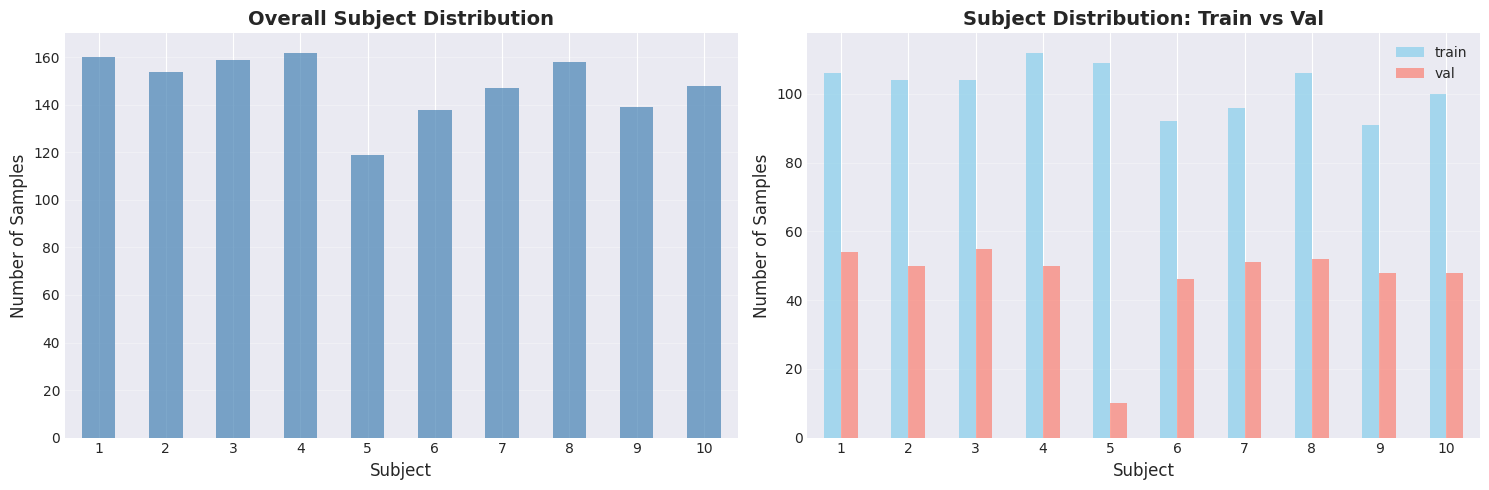

In [ ]:
# Analyze subject distribution
subject_distribution = df_files['subject'].value_counts().sort_index()
print("Subject Distribution:")
print(subject_distribution)

# Subject distribution by split

# Check for subject bias in train/val split
for subject in sorted(df_files['subject'].unique()):
    subject_data = df_files[df_files['subject'] == subject]
    total = len(subject_data)

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

subject_distribution.plot(kind='bar', ax=axes[0], color='steelblue', alpha=0.7)
axes[0].set_title('Overall Subject Distribution', fontsize=14, fontweight='bold')
action_counts.plot(kind='bar', ax=axes[0], color='skyblue')
axes[0].set_title('Action Class Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Subject', fontsize=12)
axes[0].set_ylabel('Number of Samples', fontsize=12)
axes[0].set_xticklabels(subject_distribution.index, rotation=0)
axes[0].grid(True, alpha=0.3, axis='y')

axes[1].set_xlabel('Subject', fontsize=12)
axes[1].set_ylabel('Number of Samples', fontsize=12)
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## 9. Key Observations & Modeling Implications

### Summary Statistics

In [ ]:
# Create summary statistics table
summary_stats = {
    'Metric': [
        'Total Samples',
        'Train Samples',
        'Val Samples',
        'Action Classes',
        'Joints per Skeleton',
        'Persons per Sample',
        'Camera Views',
        'Subjects',
        'Avg Sequence Length',
        'Min Sequence Length',
        'Max Sequence Length',
        'Coordinate Range (X)',
        'Coordinate Range (Y)',
        'Coordinate Range (Z)',
    ],
    'Value': [
        len(df_files),
        df_files['action'].nunique(),
        20,  # Fixed
        1,   # Fixed
        df_files['view'].nunique(),
        df_files['subject'].nunique(),
        f"{df_seq['sequence_length'].mean():.1f}",
        f"{df_seq['sequence_length'].min()}",
        f"{df_seq['sequence_length'].max()}",
        f"[{coords_array[:, :, 0].min():.2f}, {coords_array[:, :, 0].max():.2f}]",
        f"[{coords_array[:, :, 1].min():.2f}, {coords_array[:, :, 1].max():.2f}]",
        f"[{coords_array[:, :, 2].min():.2f}, {coords_array[:, :, 2].max():.2f}]",
    ]
}

df_summary = pd.DataFrame(summary_stats)
print("NW-UCLA Dataset Summary Statistics:")
print(df_summary.to_string(index=False))

NW-UCLA Dataset Summary Statistics:
              Metric         Value
       Total Samples          1484
       Train Samples          1020
         Val Samples           464
      Action Classes            10
 Joints per Skeleton            20
  Persons per Sample             1
        Camera Views             3
            Subjects            10
 Avg Sequence Length          39.4
 Min Sequence Length             1
 Max Sequence Length           201
Coordinate Range (X) [-1.65, 2.10]
Coordinate Range (Y) [-1.25, 1.40]
Coordinate Range (Z)  [1.35, 3.99]


In [ ]:
print("Key Observations:")
print("=" * 60)
print("1. Dataset Scale:")
print(f"   - Moderate size dataset with {len(df_files)} total samples")

print("\n2. Temporal Characteristics:")
print(f"   - Variable sequence lengths: {df_seq['sequence_length'].min()}-{df_seq['sequence_length'].max()} frames")
print(f"   - Average length: {df_seq['sequence_length'].mean():.1f} frames")
print(f"   - Significant variation in sequence duration across actions")

print("\n3. Spatial Characteristics:")
print(f"   - 20 joints per skeleton")
print(f"   - 3D coordinates (X, Y, Z)")
print(f"   - Joint positions show varying degrees of movement")

print("\n4. Class Distribution:")
print(f"   - {df_files['action'].nunique()} action classes")
imbalance_ratio = action_counts.max() / action_counts.min()
print(f"   - Class imbalance ratio: {imbalance_ratio:.2f}")

print("\n5. Viewpoint & Subject Variations:")
print(f"   - {df_files['view'].nunique()} camera views")
print(f"   - {df_files['subject'].nunique()} subjects")
print(f"   - Viewpoint and subject diversity present")

print("\n6. Data Quality:")
print(f"   - Missing data check: {len(df_missing[df_missing['zero_coords'] > 0])} files with zero coordinates")
print(f"   - Overall data quality appears good")

Key Observations:
1. Dataset Scale:
   - Moderate size dataset with 1484 total samples
   - Train/Val split: 1020/464

2. Temporal Characteristics:
   - Variable sequence lengths: 1-201 frames
   - Average length: 39.4 frames
   - Significant variation in sequence duration across actions

3. Spatial Characteristics:
   - 20 joints per skeleton
   - 3D coordinates (X, Y, Z)
   - Joint positions show varying degrees of movement

4. Class Distribution:
   - 10 action classes
   - Class imbalance ratio: 1.23

5. Viewpoint & Subject Variations:
   - 3 camera views
   - 10 subjects
   - Viewpoint and subject diversity present

6. Data Quality:
   - Missing data check: 0 files with zero coordinates
   - Overall data quality appears good


In [ ]:

print("\n\nModeling Implications:")
print("=" * 60)
print("1. Input Size:")
print("   - Use variable-length sequence handling or padding to fixed length")
print("   - Consider window_size around 52 frames (as used in feeder)")

print("\n2. Architecture:")
print("   - 20 input joints (not 25 like NTU)")
print("   - Single person per sample (simpler than NTU)")
print("   - Consider temporal modeling for variable-length sequences")

print("\n3. Data Augmentation:")
print("   - Viewpoint transformation (already implemented)")
print("   - Temporal augmentation (random sampling, cropping)")
print("   - Consider normalization based on coordinate statistics")

print("\n4. Training Strategy:")
print("   - Handle class imbalance if significant")
print("   - Cross-view evaluation important for generalization")
print("   - Consider subject-independent evaluation")



Modeling Implications:
1. Input Size:
   - Use variable-length sequence handling or padding to fixed length
   - Consider window_size around 52 frames (as used in feeder)

2. Architecture:
   - 20 input joints (not 25 like NTU)
   - Single person per sample (simpler than NTU)
   - Consider temporal modeling for variable-length sequences

3. Data Augmentation:
   - Viewpoint transformation (already implemented)
   - Temporal augmentation (random sampling, cropping)
   - Consider normalization based on coordinate statistics

4. Training Strategy:
   - Handle class imbalance if significant
   - Cross-view evaluation important for generalization
   - Consider subject-independent evaluation
